In [63]:
#Importowanie bibliotek
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
plt.rcParams['figure.figsize']=10,6

#Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
#Załadowanie wytrenowanej sieci do klasyfikacji zdjęć
bird_classifier=load_model('C:/Users/komej/Desktop/birds recognition/v3/bird4v2.h5')


config='C:/Users/komej/Desktop/birds recognition/rec/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model='C:/Users/komej/Desktop/birds recognition/rec/frozen_inference_graph.pb'

#Załadowanie przetrenowanej sieci do wykrywania obiektów i konfiguracja
bird_detection=cv2.dnn_DetectionModel(frozen_model,config)
bird_detection.setInputSize(384,384)
bird_detection.setInputScale(1.0/127.5)
bird_detection.setInputMean((127.5,127.5,127.5))
bird_detection.setInputSwapRB(True)

#Wczytanie dostępnych klas 
classLabels=[]
filename='C:/Users/komej/Desktop/birds recognition/rec/labels.txt'
with open(filename,'rt') as fpt:
    classLabels=fpt.read().rstrip('\n').split('\n')

def bird_finder(img_path):
    arr=[]
    #Wczytanie zdjęcia i detekcja obiektów na zdjęciu
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_to_plot=img.copy()
    img_to_plot=cv2.resize(img_to_plot,(224,224),interpolation=cv2.INTER_AREA)
    img=cv2.resize(img,(512,512),interpolation=cv2.INTER_AREA)
    classIndex,confidence,bbox=bird_detection.detect(img,confThreshold=0.2)
    for i in bbox:
        arr.append(i)
    #Zabezpiecznie gdy sieć przewidzi 2 ramki zostanie wybrana ta o większym polu
    sum_list=[]
    for ind,j in enumerate(arr):
        j=sum(j)
        sum_list.append(j)
        temp=sum_list[ind-1]
        temp2=sum_list[ind]
        if temp>temp2:
            boxx=0
        elif temp<temp2:
            boxx=1
        else:
            boxx=0
    
    #Przyciecie zdjęcia do wielkości ramki 
    cords=arr[boxx]
    im=img[cords[1]-25:cords[1]+cords[3]+25,cords[0]-40:cords[0]+cords[2]+40]
    im=cv2.resize(im,(224,224),interpolation=cv2.INTER_AREA)
    #plt.imshow(im)
    return im,img_to_plot

#img=bird_finder(r"C:\Users\komej\Desktop\birds recognition\v3\test_detector\PARUS MAJOR.jpg")
def model_prediction(img,plot):
    #img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)/255
    #img=img/255
    fig,axs=plt.subplots(1,2)
    axs[0].imshow(img)
    axs[0].set_title('Zdjęcie dopasowane')
    axs[1].imshow(plot)
    axs[1].set_title('Zdjęcie wejściowe')
    plt.show()
    img=np.expand_dims(img,axis=0)
    prediction=bird_classifier.predict(img)
    arr=prediction.tolist()
    arr_p=[]
    for l in arr:
        arr_p.append(l)
    m=np.argmax(arr_p)
    df=pd.read_csv('C:/Users/komej/Desktop/birds recognition/v3/class_dict.csv')
    print('Nazwa gatunku:',df['class'][m])
    print('Index:',m)
    print('Dokładność',prediction[0,m])

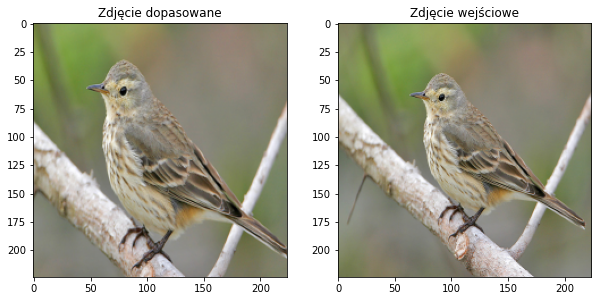

Nazwa gatunku: AMERICAN PIPIT
Index: 17
Dokładność 0.9507


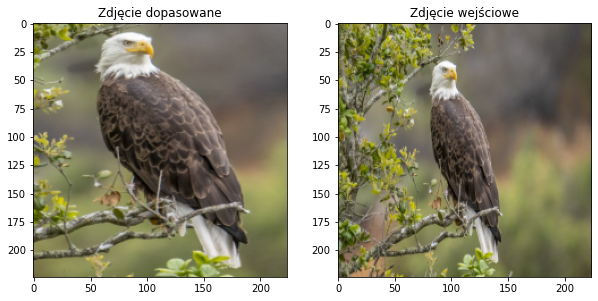

Nazwa gatunku: BALD EAGLE
Index: 38
Dokładność 0.976


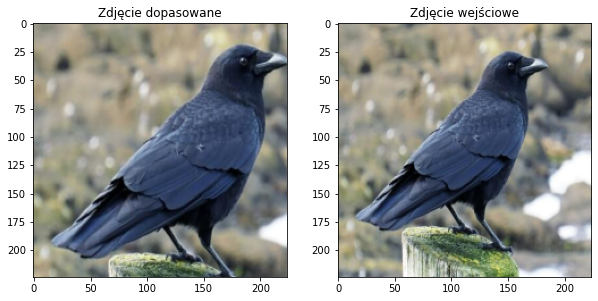

Nazwa gatunku: CROW
Index: 139
Dokładność 0.955


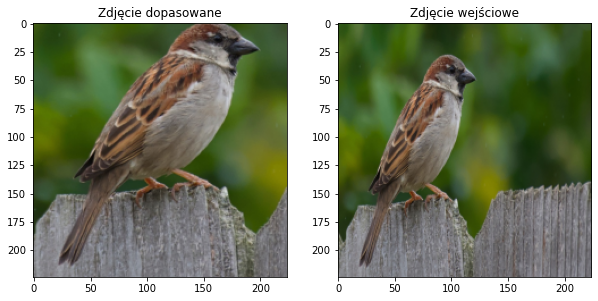

Nazwa gatunku: HOUSE SPARROW
Index: 225
Dokładność 0.991


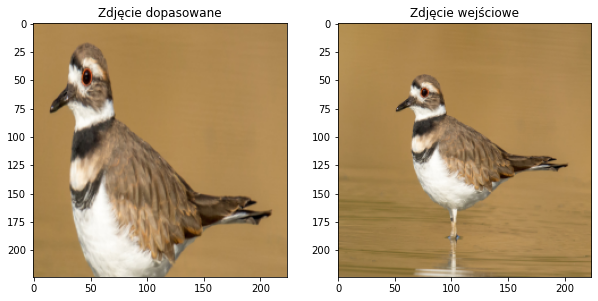

Nazwa gatunku: KILLDEAR
Index: 245
Dokładność 0.9863


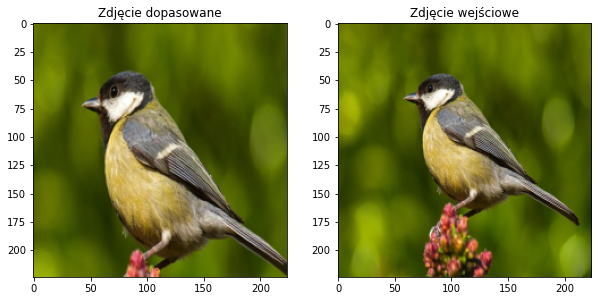

Nazwa gatunku: PARUS MAJOR
Index: 293
Dokładność 0.889


In [64]:
#Graficzna prezentacja możliwości sieci
test_path=r'C:\Users\komej\Desktop\birds recognition\v3\test_detector/'
test_dir=os.listdir(test_path)
for im in test_dir:
    img,img_in=bird_finder(test_path+im)
    model_prediction(img,img_in)

Na tych przykładach widać że sieć bardzo dobrze sobie radzi w rozpoznawaniu gatunków ptaków na zdjęciach z internetu, co pozwala na wykorzystanie tego w praktyce, aby móc rozpoznać jaki jest to gatunek ptaka na zdjęciu.